In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [15]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

In [16]:
def build_dataset(words):
    block_size = 3  # Context size
    X = []
    Y = []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join([itos[i] for i in context]), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.LongTensor(X)
    Y = torch.LongTensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [17]:
#emb = C[Xtr] #Pytoch indexind works directly on the first dimension
# emb.shape

#W1 = torch.rand((6, 100))
#b1 = torch.rand((100))

# How to h = emb. @ W1 + b1
# One way to do this
# torch.cat(torch.unbind(emb, 1), 1).shape # Generalizes to all block sizes 
# New memory is allocated for this operation

# torch.view is another way to do this : It is much more efficient and faster
# Reason is that it does not create a new tensor, it just changes the view of the tensor
# It changes the meta data of the tensor

# Read up internals of pytorch to understand this better 

#h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # No new memory is allocated here beccause of view
#h.shape

# W2 = torch.rand((100, 27))
# b2 = torch.rand((27))

# logits = h @ W2 + b2
# logits.shape
# # Like in previous example, we exp the logits and normalize them (softmax)
# probs = logits.exp() / logits.exp().sum(-1, keepdim=True)
# avg_nll = probs[torch.arange(Y.shape[0]), Y].log().mean()
# print(avg_nll)

In [18]:
###### Clean up ######
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27, 10), generator=g)
#W1 = torch.rand((30, 200), generator=g) * 0.2

W1 = torch.rand((30, 200), generator=g) * (5/3)/((10 * 3) ** 0.5) #KAIMING INITIALIZATION
b1 = torch.rand((200), generator=g) * 0.01 # Initialize with small values to avoid vanishing gradient problem with tanh
W2 = torch.rand((200, 27), generator=g) * 0.01 
b2 = torch.rand((27), generator=g) * 0 # Initialize with small values to avoid fake cconfidence in the beginning -> should be close to uniform distribution

bngain =  torch.ones((1, n_hidden)) # Batch normalization gain
bnbias = torch.zeros((1, n_hidden)) # Allows the gaussian to move around.

# -torch.tensor(1/27.0) --> This is the log of the uniform distribution 
# Our initial model should be close to this value

params = [C, W1, b1, W2, b2, bngain, bnbias]

sum(p.nelement() for p in params) # Number of parameters
for p in params:
    p.requires_grad = True

# W2 = W2 * 0.01


In [19]:
batch_size = 32
iters = 200000
#lre = torch.linspace(-3, 0, iters)
#lrs = 10**lre

lri =[]
lossi = []
stepi = []

for i in range(iters):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    emb = C[Xtr[ix]]
    assert emb.shape == (batch_size, 3, 10)
    hpreact = emb.view(-1, 30) @ W1 + b1
    # MLE estimate of the mean and variance of Gaussian
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Batch Normalization
    h = torch.tanh(hpreact) # (Eamples, 100)
    logits = h @ W2 + b2
    probs = logits.exp() / logits.exp().sum(-1, keepdim=True)
    loss = -probs[torch.arange(batch_size), Ytr[ix]].log().mean() # Creates new memory

    loss = F.cross_entropy(logits, Ytr[ix]) # Does not create new memory (Foward pass)
    # This makes backpropagation easier as well. Due to clustering the operations
    # It also take ccase of dynamic range ... ex: exp(1000) will not work but cross entropy will work


    for param in params:
        param.grad = None
    loss.backward()
    
    #lr = lrs[i]
    lr = 0.1
    for p in params:
        p.data += -lr * p.grad
    
    #lri.append(lr)   
    lossi.append(loss.log10().item())
    stepi.append(i)

    if i % 10000 == 0:
        print(f'{i:7d}/{iters:7d}: {loss.item():.3f}')


      0/ 200000: 3.280
  10000/ 200000: 2.289
  20000/ 200000: 1.989
  30000/ 200000: 2.191
  40000/ 200000: 2.447
  50000/ 200000: 2.150
  60000/ 200000: 2.487
  70000/ 200000: 1.900
  80000/ 200000: 1.966
  90000/ 200000: 1.622
 100000/ 200000: 2.090


torch.Size([32, 200])


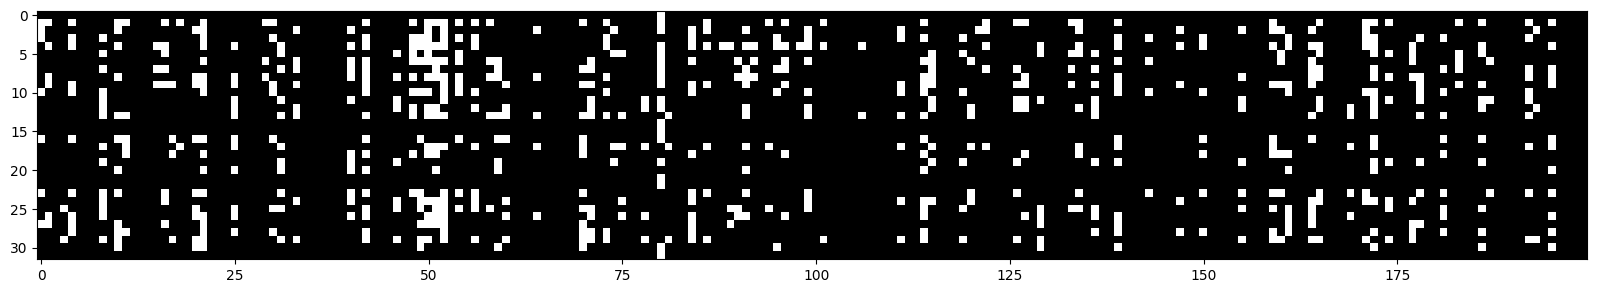

In [ ]:
plt.figure(figsize=(20,10))
print(h.shape)
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # This is a way to visualize the tanh activations
# White shows how many nerons are activated


(array([9.07132228, 6.76637883, 4.46143454, 2.85188022, 1.7658214 ,
        1.37515295, 0.83603049, 0.79696423, 0.60162941, 0.58600268,
        0.46880214, 0.4297353 , 0.28909487, 0.4297353 , 0.19533423,
        0.29690802, 0.15626738, 0.32034813, 0.21877433, 0.14064064,
        0.18752086, 0.2031479 , 0.34378824, 0.28909465, 0.28909465,
        0.23440107, 0.26565455, 0.17970749, 0.17189412, 0.21096096,
        0.26565455, 0.33597487, 0.33597487, 0.34378824, 0.36722834,
        0.25784118, 0.26565455, 0.32034813, 0.35160265, 0.4297353 ,
        0.4297353 , 0.32034813, 0.39066845, 0.36722834, 0.49224225,
        0.70320321, 0.63288289, 0.8829107 , 1.32827273, 6.75075083]),
 array([1.11354515e-04, 2.01091282e-02, 4.01069000e-02, 6.01046719e-02,
        8.01024437e-02, 1.00100219e-01, 1.20097995e-01, 1.40095770e-01,
        1.60093531e-01, 1.80091307e-01, 2.00089082e-01, 2.20086858e-01,
        2.40084633e-01, 2.60082394e-01, 2.80080169e-01, 3.00077945e-01,
        3.20075721e-01, 3.4007

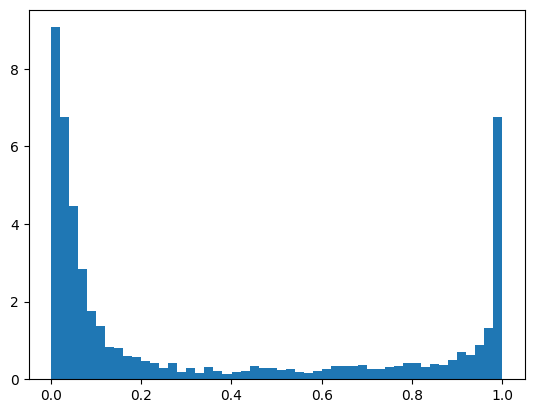

In [ ]:

plt.hist(h.abs().detach().numpy().flatten(), 50, density=True)
# To reduce the number of whites , we want to keep h to be close to 0 , Theredore we multiply W1 and b1 with small values


# The deeper and more complicated the network, the more the vanishing gradient problem
# More unforgiving it is to problems in initialization, vanishing gradient problem, dead neurons etc

# Kaiming initialization is a good way to initialize the weights and biases

In [ ]:
# Using the model to predict 
g = torch.Generator().manual_seed(2147483647)
block_size = 3
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.LongTensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        out.append(ix)
        if ix == 0:
            break
        context = context[1:] + [ix]
    
    print(''.join([itos[i] for i in out]))

junide.
jakari.
justina.
adria.
jirrito.
sabe.
ter.
brianaarianilenias.
deyaile.
imelas.
jaicayla.
terindellesti.
etum.
merynsleigh.
ani.
cora.
yarion.
jaesabi.
wer.
miki.


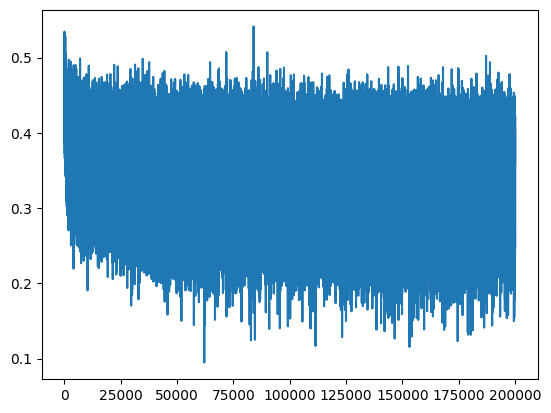

In [ ]:
#plt.plot(lri, lossi) # Used to pick out a loss
plt.plot(stepi, lossi) # Used to pick out a loss

In [ ]:
emb = C[Xdev]
hpreact = emb.view(-1, 30) @ W1 + b1
hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Batch Normalization
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f'dev Loss: {loss.item()}')

# emb = C[Xte]
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# logits = h @ W2 + b2
# loss = F.cross_entropy(logits, Yte)
# print(f'test loss {loss.item()}')
      
emb = C[Xtr]
hpreact = emb.view(-1, 30) @ W1 + b1
hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Batch Normalization
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f'train loss {loss.item()}')


dev Loss: 2.180561065673828
train loss 2.141832113265991


In [ ]:
# In production, one would make train, test and dev/validation split

# One is allowed to test on the test split only a few times
# Generally 80% train, 10% test, 10% validation


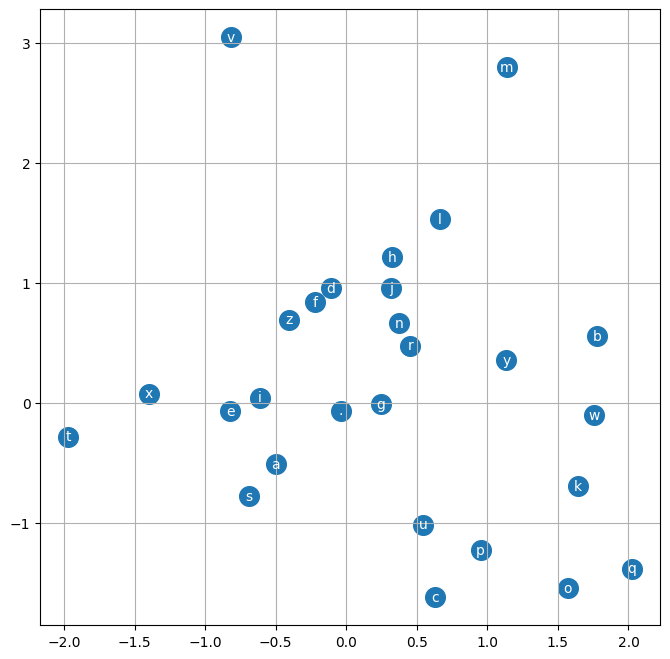

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')